In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
iris = pd.read_csv('iris.dat', header = None, delim_whitespace=True)
iris.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class']
#iris['Class'].replace([1,2,3],["setosa", 'versicolor', 'virginica'], inplace = True)
iris

,Sepal length,Sepal width,Petal length,Petal width,Class
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


### a. Perform a density estimation-based cluster analysis: Mean-shift method. How many clusters do you find?

In [3]:
# Standardized
from sklearn.preprocessing import MinMaxScaler
X = iris.iloc[:,0:4]
scaler = MinMaxScaler()
X.iloc[:,0:4] = scaler.fit_transform(X)
X

,Sepal length,Sepal width,Petal length,Petal width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


In [4]:
# Find the best bandwidth and cluster with silhouette score

from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
np.random.seed(0)
silhouette_meanshift = []
for bandwidth in np.arange(0.2,0.5,0.05):
    meanshift = MeanShift(bandwidth = bandwidth)
    clus = meanshift.fit_predict(X)
    sil_score = silhouette_score(X, clus)
    silhouette_meanshift.append((bandwidth, sil_score, len(set(meanshift.labels_))))
df_meanshift = pd.DataFrame(silhouette_meanshift, columns = ['bandwidth', 'silhouette_score', 'number_of_clusters'])
df_meanshift.sort_values('silhouette_score', ascending = False)

,bandwidth,silhouette_score,number_of_clusters
3,0.35,0.630047,2
4,0.40,0.630047,2
5,0.45,0.630047,2
2,0.30,0.476961,3
1,0.25,0.402150,5
0,0.20,0.348468,8


In [5]:
meanshift = MeanShift(bandwidth = 0.35)
clus = meanshift.fit_predict(X)
group = pd.DataFrame(clus, columns = ['cluster'])
Xmean = X.join(group)
Xmean

,Sepal length,Sepal width,Petal length,Petal width,cluster
0,0.222222,0.625000,0.067797,0.041667,1
1,0.166667,0.416667,0.067797,0.041667,1
2,0.111111,0.500000,0.050847,0.041667,1
3,0.083333,0.458333,0.084746,0.041667,1
4,0.194444,0.666667,0.067797,0.041667,1
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0
146,0.555556,0.208333,0.677966,0.750000,0
147,0.611111,0.416667,0.711864,0.791667,0
148,0.527778,0.583333,0.745763,0.916667,0


### b. Plot the first two principal component scores with the cluster label.

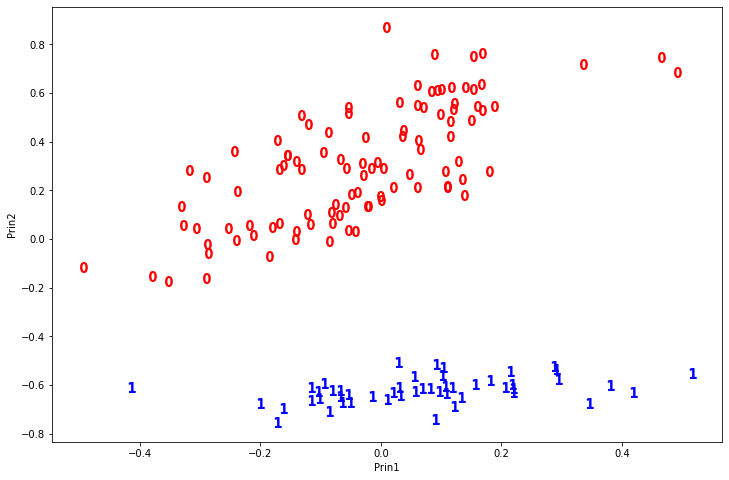

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pc = pca.fit_transform(X)
plt.figure(figsize = (12,8))
plt.xlabel('Prin1')
plt.ylabel('Prin2')
color = {0:'red', 1:'blue'}
for i in range(len(Xmean)):
    plt.scatter(pc[i,1], pc[i,0],
               marker = "$ {} $".format(Xmean['cluster'][i]),
               s = 100,
               c = color[Xmean['cluster'][i]])

### c. Compare the results of the three (hierarchical, K-means, Mean-shift) cluster analyses. Do they produce similar clusters?

#### 각 클러스링 방법으로 군집분석 진행

In [7]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
hclus = AgglomerativeClustering(n_clusters=3, metric = 'euclidean', linkage='average') # affinity 대신 metric 사용
hgroup = hclus.fit_predict(X)
hgroup = pd.DataFrame(hgroup, columns = ['cluster'])
Xgroup = X.join(hgroup)
map_dictionary = {0:1, 1:2, 2:3}
Xgroup['cluster'] = Xgroup['cluster'].map(map_dictionary) 

In [8]:
# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state = 1, n_init = 'auto').fit(X)
kgroup = pd.DataFrame(kmeans.labels_, columns = ['cluster'])
Xkmean = X.join(kgroup)
map_dictionary = {0:1, 2:2, 1:3}
Xkmean['cluster'] = Xkmean['cluster'].map(map_dictionary) 

In [9]:
# Mean-shift : cluster 개수 3으로 재설정
meanshift = MeanShift(bandwidth = 0.3)
clus = meanshift.fit_predict(X)
group = pd.DataFrame(clus, columns = ['cluster'])
Xmean = X.join(group)
map_dictionary = {1:1, 0:2, 2:3}
Xmean['cluster'] = Xmean['cluster'].map(map_dictionary)

#### 2차원상에 군집분석 결과 plot

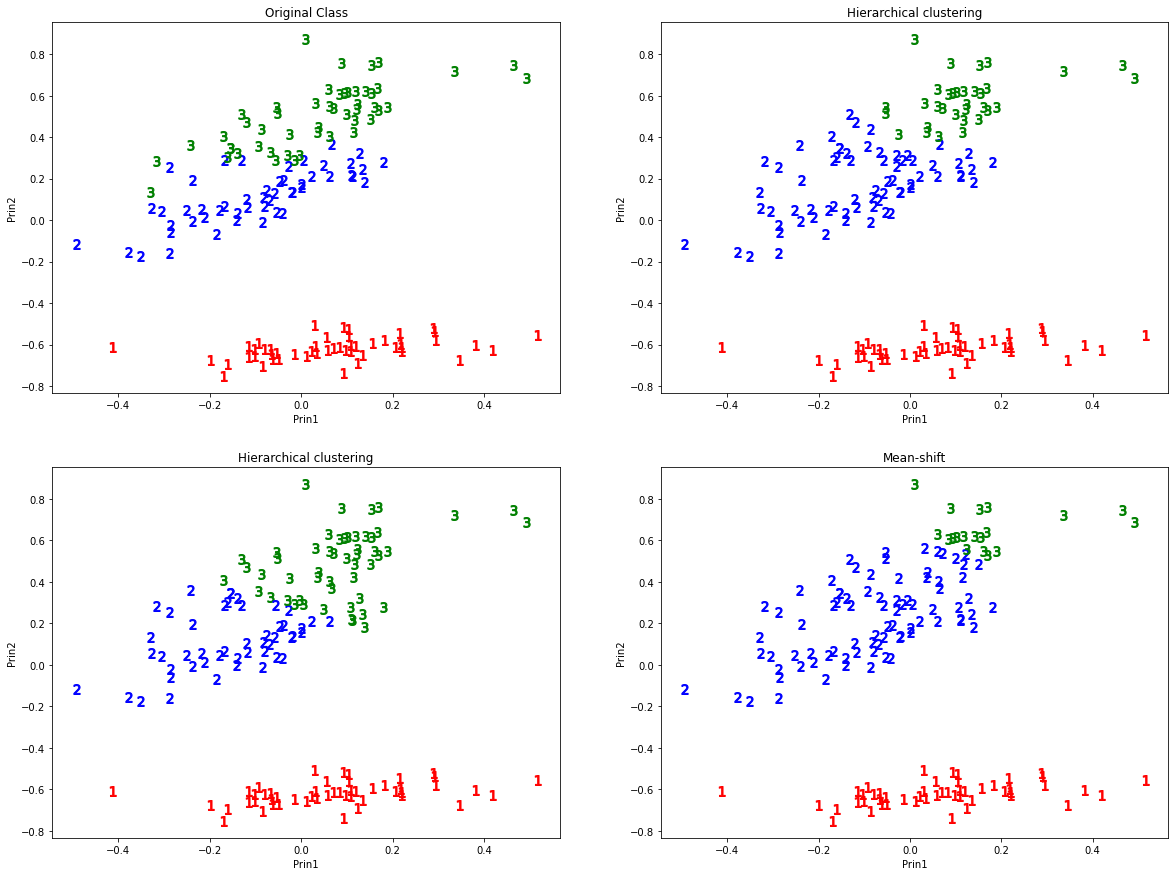

In [10]:
fig, axes = plt.subplots(2,2, figsize = (20,15))

pca = PCA(n_components = 2)
pc = pca.fit_transform(X)

color = {1:'red', 2:'blue', 3: 'green'}

# original
Xorigin = X.join(iris[['Class']])
for i in range(len(Xorigin)):
    axes[0][0].scatter(pc[i,1], pc[i,0],
               marker = "$ {} $".format(Xorigin['Class'][i]),
               s = 100,
               c = color[Xorigin['Class'][i]])
axes[0][0].set_xlabel('Prin1')
axes[0][0].set_ylabel('Prin2')
axes[0][0].set_title('Original Class')


# Hierarchical clustering
for i in range(len(Xgroup)):
    axes[0][1].scatter(pc[i,1], pc[i,0],
               marker = "$ {} $".format(Xgroup['cluster'][i]),
               s = 100,
               c = color[Xgroup['cluster'][i]])
axes[0][1].set_xlabel('Prin1')
axes[0][1].set_ylabel('Prin2')
axes[0][1].set_title('Hierarchical clustering')

# K-means
for i in range(len(Xkmean)):
    axes[1][0].scatter(pc[i,1], pc[i,0],
               marker = "$ {} $".format(Xkmean['cluster'][i]),
               s = 100,
               c = color[Xkmean['cluster'][i]])
axes[1][0].set_xlabel('Prin1')
axes[1][0].set_ylabel('Prin2')
axes[1][0].set_title('Hierarchical clustering')

# Mean-shift
for i in range(len(Xmean)):
    axes[1][1].scatter(pc[i,1], pc[i,0],
               marker = "$ {} $".format(Xmean['cluster'][i]),
               s = 100,
               c = color[Xmean['cluster'][i]])
axes[1][1].set_xlabel('Prin1')
axes[1][1].set_ylabel('Prin2')
axes[1][1].set_title('Mean-shift')


plt.show()

#### Confusion Matrix

In [11]:
# Hierarchical clustering vs. Original

actual = Xorigin['Class']
pred = Xgroup['cluster']

C1 = pd.DataFrame(confusion_matrix(actual, pred),
                  index = np.sort(Xorigin['Class'].unique()), 
                  columns = np.sort(np.unique(Xgroup['cluster'])))
C1['Total'] = C1.sum(axis = 1) #row sum
C1.loc['Total',:] = C1.sum(axis = 0) # column sum
C1.index.names = ['From Class'] ; C1.columns.names = ['Classified Class']
C1.astype(int)

Classified Class,1,2,3,Total
From Class,,,,
1,50,0,0,50
2,0,50,0,50
3,0,17,33,50
Total,50,67,33,150


In [12]:
# K-means vs. Original
actual = Xorigin['Class']
pred = Xkmean['cluster']

C1 = pd.DataFrame(confusion_matrix(actual, pred),
                  index = np.sort(Xorigin['Class'].unique()), 
                  columns = np.sort(np.unique(Xkmean['cluster'])))
C1['Total'] = C1.sum(axis = 1) #row sum
C1.loc['Total',:] = C1.sum(axis = 0) # column sum
C1.index.names = ['From Class'] ; C1.columns.names = ['Classified Class']
C1.astype(int)

Classified Class,1,2,3,Total
From Class,,,,
1,50,0,0,50
2,0,40,10,50
3,0,8,42,50
Total,50,48,52,150


In [13]:
# Mean-shfit vs. Original

actual = Xorigin['Class']
pred = Xmean['cluster']

C1 = pd.DataFrame(confusion_matrix(actual, pred),
                  index = np.sort(Xorigin['Class'].unique()), 
                  columns = np.sort(np.unique(Xmean['cluster'])))
C1['Total'] = C1.sum(axis = 1) #row sum
C1.loc['Total',:] = C1.sum(axis = 0) # column sum
C1.index.names = ['From Class'] ; C1.columns.names = ['Classified Class']
C1.astype(int)

Classified Class,1,2,3,Total
From Class,,,,
1,50,0,0,50
2,0,50,0,50
3,0,31,19,50
Total,50,81,19,150
